#Predição do Bitcoin com RNN

###Esse projeto tem como objetivo construir um modelo que prevê os valores futuros de Bitcoin do dataset abaixo:
https://www.kaggle.com/mczielinski/bitcoin-historical-data

###Esse dataset contêm os valores de transações de Bitcoin de minuto a minuto desde 01/01/2012 até 22/04/2020, com as seguintes colunas:
- Timestamp (começo da janela de tempo de um minuto em horário Unix)
- Open (preço inicial)
- High (maior preço)
- Low (menor preço)
- Close (preço final)
- Volume_(BTC) (quantidade de Bitcoin transacionado)
- Volume_(Currency) (quantidade de moeda transacionado)
- Weighted_Price (preço médio)

Usaremos a variavel Timestamp para sequênciar os valores e tentaremos predizer a variável Weighted_Price.

In [0]:
from google.colab import drive
drive.mount('/content/drive')
caminho_drive = '/content/drive/My Drive/colab/RNN/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Primeiro vamos importar as bibliotecas que usaremos durante todo o notebook.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from datetime import datetime, timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

Agora importamos o arquivo para começar a análise.

In [0]:
nm_arquivo = 'bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv'
arquivo = pd.read_csv( caminho_drive + nm_arquivo )

In [0]:
arquivo.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,4.363457e+06,3.126480e+06,3.126480e+06,3.126480e+06,3.126480e+06,3.126480e+06,3.126480e+06,3.126480e+06
mean,1.456469e+09,3.674656e+03,3.677366e+03,3.671730e+03,3.674595e+03,9.855040e+00,2.884459e+04,3.674570e+03
std,7.573296e+07,3.935578e+03,3.939077e+03,3.931713e+03,3.935490e+03,3.229272e+01,1.010277e+05,3.935458e+03
min,1.325318e+09,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.390770e+09,4.100000e+02,4.102400e+02,4.098300e+02,4.100000e+02,3.988120e-01,3.503759e+02,4.099998e+02
50%,1.456610e+09,1.175140e+03,1.175770e+03,1.174825e+03,1.175140e+03,1.990000e+00,2.620491e+03,1.175200e+03
75%,1.522062e+09,6.931175e+03,6.935780e+03,6.926790e+03,6.931225e+03,7.639098e+00,1.760057e+04,6.931180e+03
max,1.587514e+09,1.966576e+04,1.966600e+04,1.964996e+04,1.966575e+04,5.853852e+03,7.569437e+06,1.966330e+04


In [0]:
arquivo.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


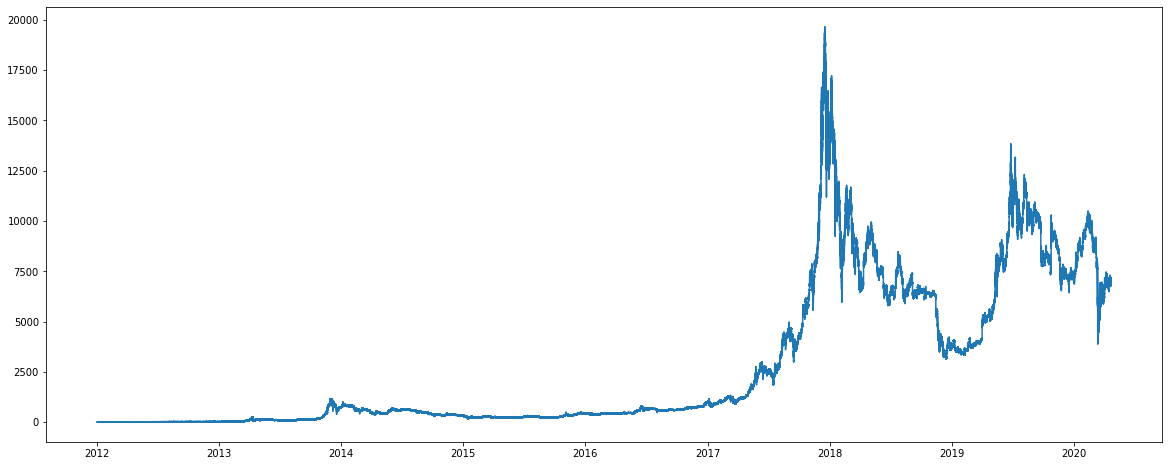

In [0]:
x_plot = pd.to_datetime(arquivo['Timestamp'], unit='s')

plt.figure( figsize=(20, 8) )
plt.plot( x_plot, arquivo['Weighted_Price'] )

Primeira coisa que podemos perceber é que antes de 2017 temos muitos valores NaN, que significa que não tinhamos muitas transações da moeda.

Alem disso a quantidade de dados do arquivo é bem grande, então vamos filtrar os dados para pegar apenas os dados de 2020, para evitar que a RAM do Google Colab estore o limite quando prepararmos os dados da rede.

In [0]:
dt = datetime(2020, 1, 1)
timestamp = dt.replace(tzinfo=timezone.utc).timestamp()

arquivo_filtro_data = arquivo[ arquivo['Timestamp'] >= timestamp ]

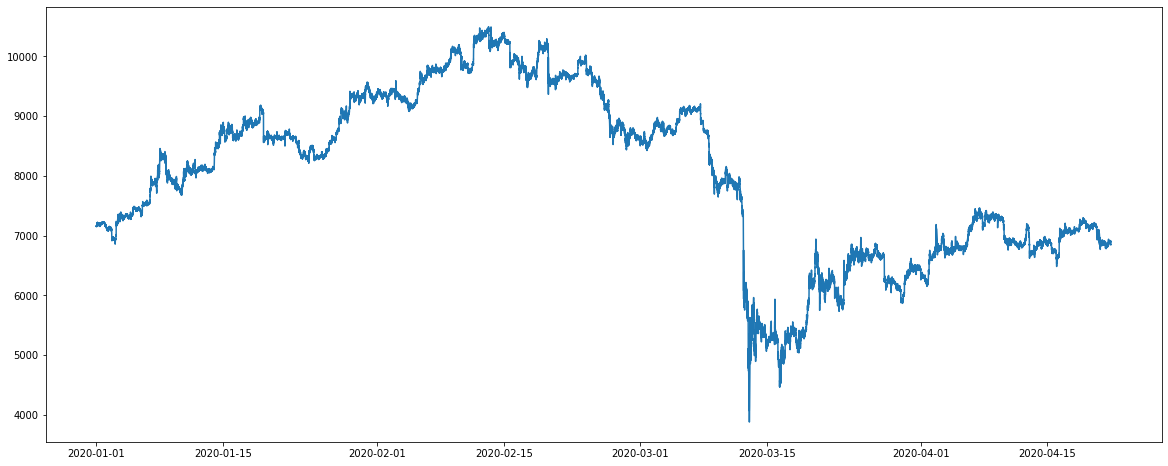

In [0]:
x_plot = pd.to_datetime(arquivo_filtro_data['Timestamp'], unit='s')

plt.figure( figsize=(20, 8) )
plt.plot( x_plot, arquivo_filtro_data['Weighted_Price'] )

In [0]:
arquivo_filtro_data.isna().sum()

Timestamp               0
Open                 1650
High                 1650
Low                  1650
Close                1650
Volume_(BTC)         1650
Volume_(Currency)    1650
Weighted_Price       1650
dtype: int64

Mesmo filtrando o arquivo apenas para 2020, ainda temos casos NaN. Uma linha de Nan significa que não teve nenhuma transação na janela de tempo indicada, ou seja, o valor continuou igual, logo, uma ideia para preencher os valores vazios é de preencher todos os valores com o Close da última linha.


In [0]:
arquivo_filtro_data.sort_values( by=['Timestamp'] ) #garantido a seqência dos valores
arquivo_na = arquivo_filtro_data.copy()

for i in range( arquivo_filtro_data.shape[0] ):
    if (i % 100000 == 0):
        print( '{}/{} dados processados'.format( i, arquivo_filtro_data.shape[0] ) )
    if pd.isna( arquivo_filtro_data.iloc[i][1] ):
        valor_close = arquivo_na.iloc[i - 1][4]
        arquivo_na.iloc[i] = [ arquivo_na.iloc[i][0] , valor_close , valor_close , valor_close , valor_close , 0 , 0 , valor_close ]

print( '{}/{} dados processados'.format( arquivo_filtro_data.shape[0], arquivo_filtro_data.shape[0] ) )

0/161281 dados processados
100000/161281 dados processados
161281/161281 dados processados


In [0]:
arquivo_na.isna().sum()

Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

Olhando a página do dataset o autor diz que podem ter timestamps que não existem, que no momento da janela de tempo, a API que captura os arquivos não estava funcionando. Vamos ver se é muito grande essa quantidade.

In [0]:
valor_minimo = arquivo_na['Timestamp'].min()
valor_maximo = arquivo_na['Timestamp'].max()

quantidade_desejada = int( ( valor_maximo - valor_minimo ) / 60 ) + 1
quantidade_real = arquivo_na.shape[0]

diferenca = quantidade_desejada - quantidade_real
diference_percentual = (diferenca / quantidade_desejada) * 100

print('São {0} linhas não existentes em {1} linhas'.format(diferenca, quantidade_desejada))

São 0 linhas não existentes em 161281 linhas


Como podemos ver, em 2020 não temos casos que a API não estava funcionando, então não precisamos nos preocupar.

Com os dados limpos, podemos analisar a correlação da variável Y do projeto com ela mesma para ter ideias com isso.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


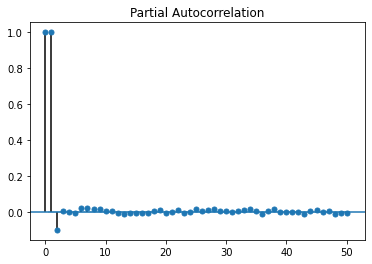

In [0]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(arquivo_na['Weighted_Price'], lags=50)
plt.show()

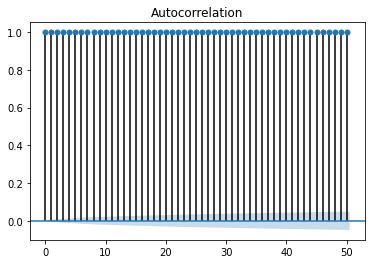

In [0]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(arquivo_na['Weighted_Price'], lags=50)
plt.show()

O primeiro gráfico mostra a correlação da variável Weighted_Price com ela mesma no tempo, ou seja, qual a relação dela no tempo 0 com ela no tempo t. Com isso podemos ver que depois de 3 time_steps não temos mais muita correlação, nos dizendo que colocar um time_step muito grande não vai fazer tanta diferença quanto um time_step = 3.

O segundo gráfico mostra a correlação da variável Weighted_Price com ela mesma no tempo, mas nessa visualização de forma cumulativa. Com isso podemos ver que o problema de predição dessa variável pode ser atacado por uma Rede Neural Recorrente pois ela tem muita correlação atravez do tempo.

Agora podemos preparar os dados que vão entrar no modelo.

Primeiro dividimos os dados de treino, validação e teste, nesse caso dividindo 70% para treino, 15% para validação e o resto para teste.

In [0]:
arquivo_np = arquivo_na[  arquivo_na.columns[1:] ].to_numpy() #pega todas as colunas, menos a de data, e transforma em uma array

porc_treino = 0.7
porc_validacao = 0.15

qnt_total = arquivo_np.shape[0]
qnt_treino = int( qnt_total * porc_treino )
qnt_validacao = int( qnt_total * porc_validacao )

dados_treino = arquivo_np[ : qnt_treino ]
dados_validacao = arquivo_np[ qnt_treino : qnt_treino + qnt_validacao ]
dados_teste = arquivo_np[ qnt_treino + qnt_validacao : ]

qnt_teste = dados_teste.shape[0]

print('{} dados no total'.format( qnt_total ))
print('{} dados para o treino'.format( dados_treino.shape[0] ))
print('{} dados para a validação'.format( dados_validacao.shape[0] ))
print('{} dados para o teste'.format( dados_teste.shape[0] ))

161281 dados no total
112896 dados para o treino
24192 dados para a validação
24193 dados para o teste


Em seguida, normalizamos os dados a partir dos dados de treino.

In [0]:
scaler = MinMaxScaler( feature_range=(0,1) )

dados_treino_norm = scaler.fit_transform( dados_treino )
dados_validacao_norm = scaler.transform( dados_validacao )
dados_teste_norm = scaler.transform( dados_teste )

dados_treino_norm

array([[4.97222862e-01, 4.91924332e-01, 4.98150172e-01, ...,
        7.06382071e-03, 8.06158968e-03, 4.95870190e-01],
       [4.97346324e-01, 4.92049076e-01, 4.97465329e-01, ...,
        4.84933036e-03, 5.53517440e-03, 4.96040764e-01],
       [4.96941309e-01, 4.91639854e-01, 4.98026750e-01, ...,
        3.75909838e-05, 4.28932524e-05, 4.95681674e-01],
       ...,
       [2.52750413e-01, 2.44912489e-01, 2.48132863e-01, ...,
        9.58862835e-02, 8.42903410e-02, 2.47501371e-01],
       [2.48052842e-01, 2.41431820e-01, 2.48325522e-01, ...,
        2.49936214e-02, 2.19492565e-02, 2.46675933e-01],
       [2.48343429e-01, 2.42505838e-01, 2.49291827e-01, ...,
        1.37911762e-02, 1.21112320e-02, 2.46669022e-01]])


Para finalizar a preparação dos dados vamos coloca-los no formato certo para entrar no modelo, onde cada exemplo de X terá (time_steps) linhas e (nr_features) colunas, e nosso Y sera os proximos (future_steps) valores do preço médio.

Como vamos fazer diferentes testes com diferentes valores de time_steps e future_steps, vamos criar uma função para essa formatação.

In [0]:
def prepara_steps( time_steps, future_steps ):

    X_treino = []
    Y_treino = []

    for i in range (time_steps, qnt_treino - future_steps):
        X_treino.append( dados_treino_norm[i - time_steps : i] )
        Y_treino.append( dados_treino_norm[i : i + future_steps , -1] )

    X_treino = np.array(X_treino)
    Y_treino = np.array(Y_treino)


    X_validacao = []
    Y_validacao = []

    for i in range(time_steps, qnt_validacao - future_steps):
        X_validacao.append( dados_validacao_norm[i - time_steps : i] )
        Y_validacao.append( dados_validacao_norm[i : i + future_steps, -1] )
    
    X_validacao = np.array(X_validacao)
    Y_validacao = np.array(Y_validacao)


    X_teste = []
    Y_teste = []
    
    for i in range(time_steps, qnt_teste - future_steps):
        X_teste.append( dados_teste_norm[i - time_steps : i] )
        Y_teste.append( dados_teste_norm[i : i + future_steps, -1] )
    
    X_teste = np.array(X_teste)
    Y_teste = np.array(Y_teste)

    return X_treino, Y_treino, X_validacao, Y_validacao, X_teste, Y_teste

Como ainda temos muito dados, podemos usar um numero de time steps grande (tomando cuidado para não deixar grande demais a ponto de estourar a RAM do Google Colab).

As transações de Bitcoin são feitas com uma demora de em média 10 minutos, com isso, devemos tentar predizer valores com pelo menos 10 minutos a frente, ou seja, o nosso future_steps deve ser >= 10.

Como um primeiro teste, vamos colocar um time_steps = 60 e um future_steps = 10.

In [0]:
time_steps = 60
nr_features = arquivo_na.shape[1] - 1 #tiramos a variável de tempo
future_steps = 10
X_treino, Y_treino, X_validacao, Y_validacao, X_teste, Y_teste = prepara_steps( time_steps, future_steps )

print('Dimensão dos dados de entrada do treinamento:', X_treino.shape)
print('Dimensão dos dados de saída do treinamento:',Y_treino.shape)

print('Dimensão dos dados de entrada da validação:', X_validacao.shape)
print('Dimensão dos dados de saída da validação:', Y_validacao.shape)

print('Dimensão dos dados de entrada do teste:', X_teste.shape)
print('Dimensão dos dados de saída do teste:', Y_teste.shape)

Dimensão dos dados de entrada do treinamento: (112826, 60, 7)
Dimensão dos dados de saída do treinamento: (112826, 10)
Dimensão dos dados de entrada da validação: (24122, 60, 7)
Dimensão dos dados de saída da validação: (24122, 10)
Dimensão dos dados de entrada do teste: (24123, 60, 7)
Dimensão dos dados de saída do teste: (24123, 10)


In [0]:
X_treino[0]

array([[4.97222862e-01, 4.91924332e-01, 4.98150172e-01, 4.96554635e-01,
        7.06382071e-03, 8.06158968e-03, 4.95870190e-01],
       [4.97346324e-01, 4.92049076e-01, 4.97465329e-01, 4.96789751e-01,
        4.84933036e-03, 5.53517440e-03, 4.96040764e-01],
       [4.96941309e-01, 4.91639854e-01, 4.98026750e-01, 4.96431047e-01,
        3.75909838e-05, 4.28932524e-05, 4.95681674e-01],
       [4.96941309e-01, 4.91639854e-01, 4.97737761e-01, 4.96141673e-01,
        8.45078517e-05, 9.64211102e-05, 4.95606463e-01],
       [4.96893129e-01, 4.91591174e-01, 4.97447267e-01, 4.96186888e-01,
        1.24719864e-03, 1.42240547e-03, 4.95140469e-01],
       [4.96595014e-01, 4.91744822e-01, 4.96714259e-01, 4.96382818e-01,
        1.13876371e-03, 1.29805117e-03, 4.94569472e-01],
       [4.96700408e-01, 4.91597259e-01, 4.97152258e-01, 4.95555388e-01,
        1.40995694e-04, 1.60846931e-04, 4.95436896e-01],
       [4.96232156e-01, 4.90923336e-01, 4.97317824e-01, 4.95721176e-01,
        1.16982195e-03, 1

In [0]:
Y_treino[0]

array([0.49443734, 0.49436451, 0.49536261, 0.49540368, 0.49512602,
       0.49545821, 0.49598854, 0.49694544, 0.49671933, 0.49589608])

Vemos que nossos dados estão no formato certo, então podemos agora ir para o nosso modelo.

Da mesma forma que a formatação dos dados, vamos criar uma função que cria um modelo e nós só precisamos informar os paraêmtros da rede, para podermos utilizar essa função diversas vezes.

In [0]:
def cria_modelo( n_neuronios, n_camadas, optimizer, time_steps, nr_features, future_steps ):
    model = Sequential()

    for i in range( n_camadas ):
        if i == 0 and n_camadas > 1:
            model.add( LSTM(units=n_neuronios, input_shape=(time_steps, nr_features), return_sequences=True) )
        elif i == 0 and n_camadas == 1:
            model.add( LSTM(units=n_neuronios, input_shape=(time_steps, nr_features)) )
        elif i < n_camadas - 1:
            model.add( LSTM(units=n_neuronios, return_sequences=True) )
        else:
            model.add( LSTM(units=n_neuronios) )

    model.add( Dense(units=future_steps) )

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

    model.summary()

    return model

Como ultimas definições antes do treino, vamos instanciar uma variável do dia e hora de agora, para salvarmos os arquivos, uma variável do caminho de onde vamos exportar esses arquivos e definir os callbacks que usaremos no treino dos modelos.

In [0]:
agora = str( datetime.now() - timedelta(hours = 3) ).replace(' ', '_')[:19] #horario de brasilia UTC-3

caminho_export = '{0}{1}_'.format( caminho_drive, agora )

callbacks = [] #salvar os resultados e o modelo para se o colab cair
callbacks.append( CSVLogger( '{0}log.log'.format( caminho_export ) ) )
callbacks.append( ModelCheckpoint( '{0}model_rnn.h5f'.format( caminho_export, verbose=0, save_freq='epoch' ) ) )

Com os dados preparados e o modelo criado, podemos agora começar o treino. Vamos utilizar 100 épocas para ver sua performance e tirar ideias disso.

In [0]:
model = cria_modelo( 30, 1, 'adam', time_steps, nr_features, future_steps )

historico = model.fit(X_treino, Y_treino, epochs=100, batch_size=time_steps, validation_data=(X_validacao, Y_validacao), shuffle=False, callbacks=callbacks)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                4560      
_________________________________________________________________
dense (Dense)                (None, 10)                310       
Total params: 4,870
Trainable params: 4,870
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1881/1881 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.1020WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/co

Com o modelo treinado vamos ver como a rede se comportou durante esse treino, para isso criaremos uma função que plota os dados da função de custo por época, e da exatidão por época.

In [0]:
def plota_treinamento( historico ):
    plt.plot(historico.history['loss'], 'b', label='Treinamento')
    plt.plot(historico.history['val_loss'], 'bo', label='Validação')
    plt.title('Função de custo por época')
    plt.xlabel('Épocas')
    plt.ylabel('Custo')
    plt.legend()
    plt.show()
    plt.savefig('{0}result_custo.png'.format( caminho_export ), bbox_inches='tight') #salva o grafico em uma foto

    plt.plot(historico.history['accuracy'], 'b', label='Treinamento')
    plt.plot(historico.history['val_accuracy'], 'bo', label='Validação')
    plt.title('Exatidão por época')
    plt.xlabel('Épocas')
    plt.ylabel('Exatidão')
    plt.legend()
    plt.show()
    plt.savefig('{0}result_exatidao.png'.format( caminho_export ), bbox_inches='tight') #salva o grafico em uma foto

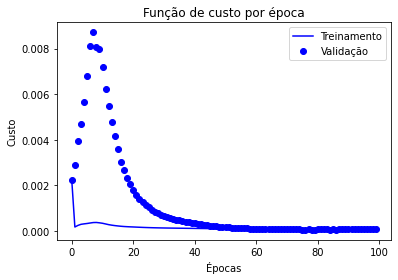

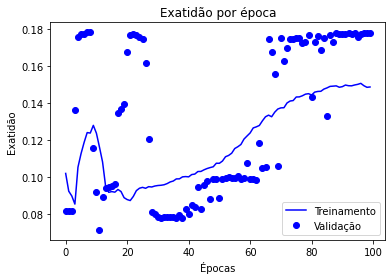

<Figure size 432x288 with 0 Axes>

In [0]:
plota_treinamento(historico)

Analisando os gráficos das métricas, podemos ver que depois de poucas épocas o valor de custo estabiliza, então podemos rodar os próximos testes com menos epocas, com objetivo de agilizar o treino.

Vamos agora analisar como a rede está prevendo os dados, para isso vamos usar o modelo para predizer quais saídas o modelo acredita que serão a partir dos dados de entrada do teste.

In [0]:
Y_predict = model.predict( X_teste )

In [0]:
Y_teste[0].shape

(10,)

Como vamos usar essa visualização das predições diversas vezes, vamos também criar uma função.

In [0]:
def plota_predicao( future_step_prediction=[], cores=[] ):
    plt.figure(figsize=(30,14))

    plt.plot( Y_teste[time_steps:, 0], linewidth=2 ,color='red',label='Real' )
    plt.plot( Y_predict[:, 0], color='black', linewidth=1, label='Predição 1 dia' )

    for i in range(len(future_step_prediction)):
        predicao = future_step_prediction[i]
        cor = cores[i]
        lista_pre_predicao = []
        for i in range(predicao):
            lista_pre_predicao.append(None)
        plt.plot( np.concatenate((lista_pre_predicao,Y_predict[:, predicao-1])), color=cor, linewidth=1 ,label='Predição {0} dias'.format(predicao) )

    plt.title('Predição')
    plt.xlabel('Dias')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()

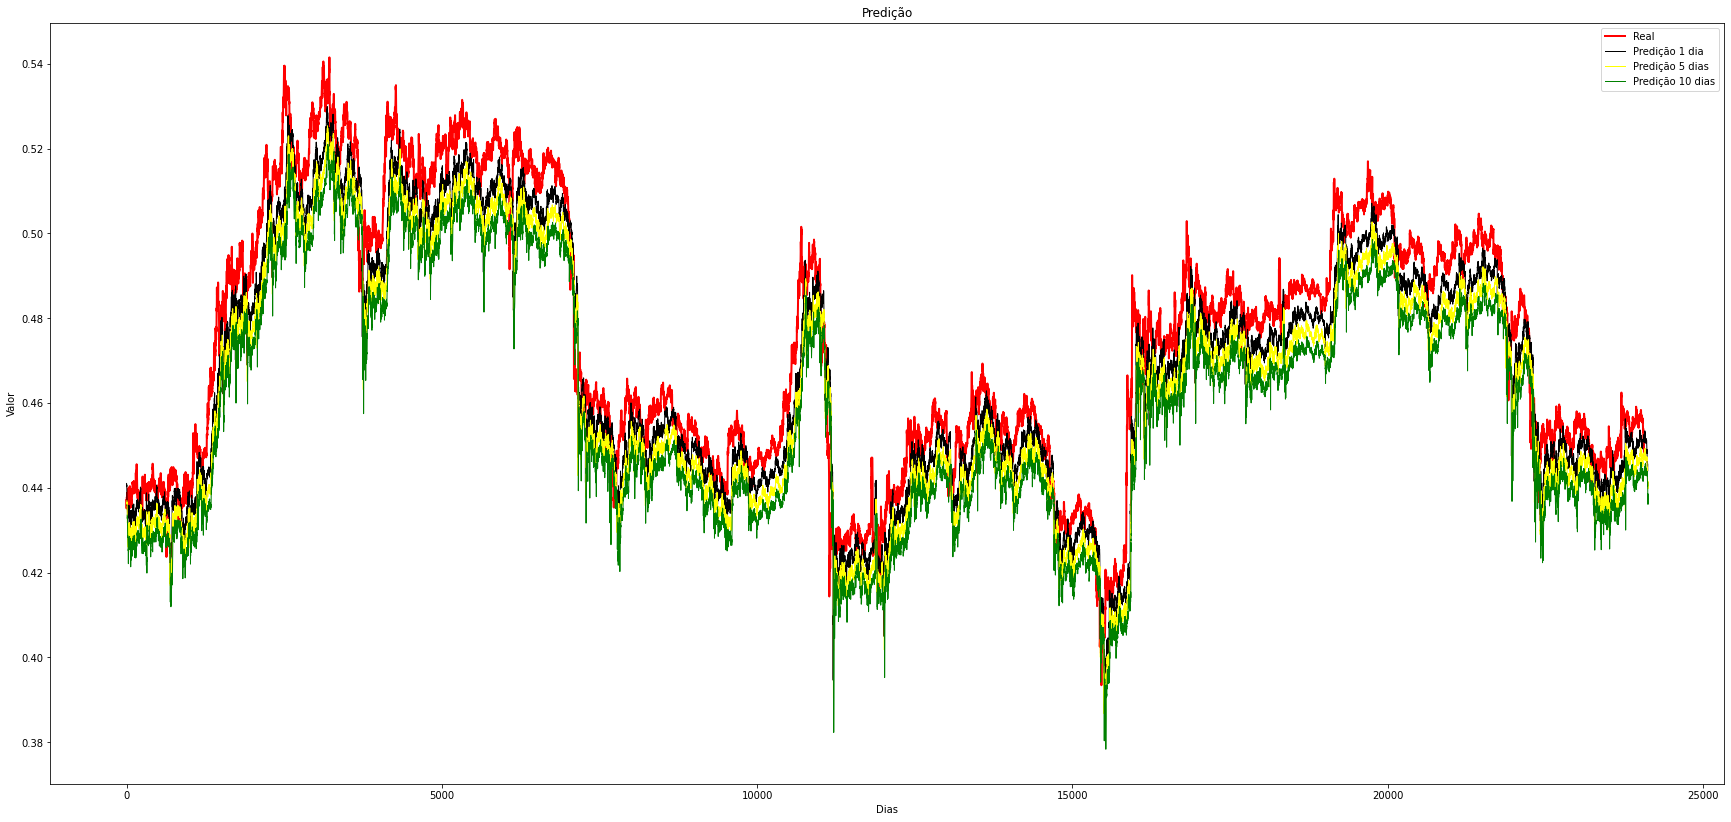

In [0]:
plota_predicao( [5, 10], ['yellow', 'green'] )

Analisando o gráfico, a rede está conseguindo prever bem os dados, mas isso é um problema que a rede está "shiftando" os dados, que significa que ela está apenas pegando os dados anteriories que ela tem na memoria e usando como saída, dessa forma acertando muito proximo o comportamento da curva, logo, isso é um problema. Além disso podemos ver que a grandeza dos dados fica menor do que o esperado quanto mais longe tentamos prever, que é outro problema.

Antes de atacarmos esses problemas vamos testar outras redes, e para isso vamos criar uma lista para os hyperparametro que desejamos e testar os conjuntos deles separadamente, salvando o resultado e os gráficos de acompanhamento do treino no drive, e como comentado anteiormente, vamos usar apenas 20 épocas no treino para agilizar o processo.

In [0]:
n_neurons_list = [ 16, 32, 64 ]

n_camadas_list = [1, 2, 3]

optimizer_list = ['adam', 'rmsprop']

batch_list = [ 16, 32, 64 ]

16 neuronios, camadas 1, otimizador adam, batch_size 16
Epoch 1/20
7052/7052 [==============================] - 152s 22ms/step - loss: 0.0021 - accuracy: 0.1098 - val_loss: 0.0230 - val_accuracy: 0.1667
Epoch 2/20
7052/7052 [==============================] - 152s 22ms/step - loss: 2.0154e-04 - accuracy: 0.1025 - val_loss: 0.0226 - val_accuracy: 0.0993
Epoch 3/20
7052/7052 [==============================] - 152s 22ms/step - loss: 2.0397e-04 - accuracy: 0.0999 - val_loss: 0.0226 - val_accuracy: 0.0992
Epoch 4/20
7052/7052 [==============================] - 152s 21ms/step - loss: 1.9957e-04 - accuracy: 0.0920 - val_loss: 0.0208 - val_accuracy: 0.0816
Epoch 5/20
7052/7052 [==============================] - 154s 22ms/step - loss: 1.7765e-04 - accuracy: 0.0942 - val_loss: 0.0180 - val_accuracy: 0.0815
Epoch 6/20
7052/7052 [==============================] - 155s 22ms/step - loss: 1.5008e-04 - accuracy: 0.1040 - val_loss: 0.0149 - val_accuracy: 0.0990
Epoch 7/20
7052/7052 [====================

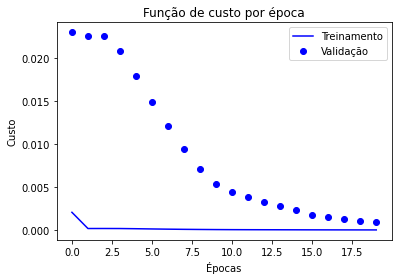

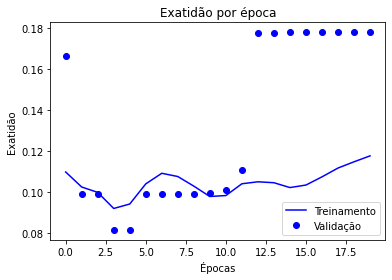

32 neuronios, camadas 1, otimizador adam, batch_size 16
Epoch 1/20
7052/7052 [==============================] - 157s 22ms/step - loss: 4.9099e-04 - accuracy: 0.0952 - val_loss: 0.0183 - val_accuracy: 0.0815
Epoch 2/20
7052/7052 [==============================] - 159s 23ms/step - loss: 1.8006e-04 - accuracy: 0.0995 - val_loss: 0.0214 - val_accuracy: 0.0816
Epoch 3/20
7052/7052 [==============================] - 156s 22ms/step - loss: 1.9125e-04 - accuracy: 0.1057 - val_loss: 0.0215 - val_accuracy: 0.0816
Epoch 4/20
7052/7052 [==============================] - 155s 22ms/step - loss: 1.9059e-04 - accuracy: 0.1118 - val_loss: 0.0193 - val_accuracy: 0.0815
Epoch 5/20
7052/7052 [==============================] - 156s 22ms/step - loss: 1.6581e-04 - accuracy: 0.1083 - val_loss: 0.0165 - val_accuracy: 0.0821
Epoch 6/20
7052/7052 [==============================] - 158s 22ms/step - loss: 1.4101e-04 - accuracy: 0.1099 - val_loss: 0.0137 - val_accuracy: 0.1659
Epoch 7/20
7052/7052 [================

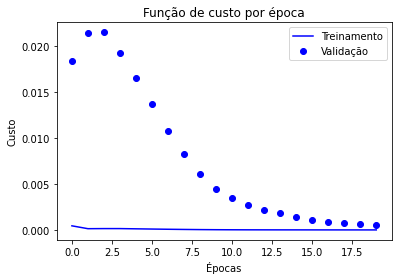

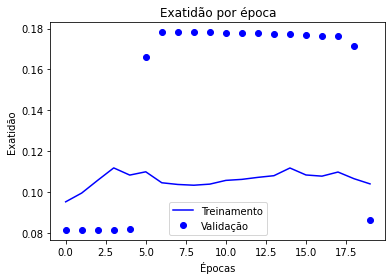

64 neuronios, camadas 1, otimizador adam, batch_size 16
Epoch 1/20
7052/7052 [==============================] - 189s 27ms/step - loss: 4.1372e-04 - accuracy: 0.1109 - val_loss: 0.0206 - val_accuracy: 0.1782
Epoch 2/20
7052/7052 [==============================] - 188s 27ms/step - loss: 1.8263e-04 - accuracy: 0.1143 - val_loss: 0.0221 - val_accuracy: 0.1001
Epoch 3/20
7052/7052 [==============================] - 191s 27ms/step - loss: 1.8438e-04 - accuracy: 0.1056 - val_loss: 0.0211 - val_accuracy: 0.1041
Epoch 4/20
7052/7052 [==============================] - 193s 27ms/step - loss: 1.8080e-04 - accuracy: 0.1078 - val_loss: 0.0194 - val_accuracy: 0.0993
Epoch 5/20
7052/7052 [==============================] - 191s 27ms/step - loss: 1.6426e-04 - accuracy: 0.1018 - val_loss: 0.0165 - val_accuracy: 0.0993
Epoch 6/20
7052/7052 [==============================] - 189s 27ms/step - loss: 1.4081e-04 - accuracy: 0.1043 - val_loss: 0.0132 - val_accuracy: 0.1710
Epoch 7/20
7052/7052 [================

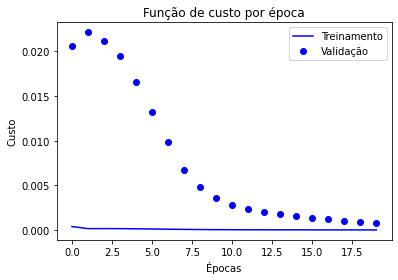

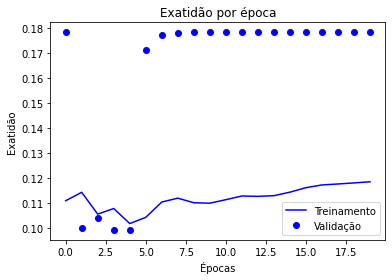

16 neuronios, camadas 2, otimizador adam, batch_size 16
Epoch 1/20
7052/7052 [==============================] - 305s 43ms/step - loss: 8.5913e-04 - accuracy: 0.0920 - val_loss: 0.0243 - val_accuracy: 0.0743
Epoch 2/20
7052/7052 [==============================] - 308s 44ms/step - loss: 2.2668e-04 - accuracy: 0.0875 - val_loss: 0.0253 - val_accuracy: 0.0728
Epoch 3/20
7052/7052 [==============================] - 309s 44ms/step - loss: 2.5013e-04 - accuracy: 0.1092 - val_loss: 0.0261 - val_accuracy: 0.0728
Epoch 4/20
7052/7052 [==============================] - 308s 44ms/step - loss: 2.7226e-04 - accuracy: 0.1155 - val_loss: 0.0263 - val_accuracy: 0.0857
Epoch 5/20
7052/7052 [==============================] - 310s 44ms/step - loss: 2.8097e-04 - accuracy: 0.1137 - val_loss: 0.0251 - val_accuracy: 0.0734
Epoch 6/20
7052/7052 [==============================] - 308s 44ms/step - loss: 2.6332e-04 - accuracy: 0.1115 - val_loss: 0.0214 - val_accuracy: 0.0714
Epoch 7/20
7052/7052 [================

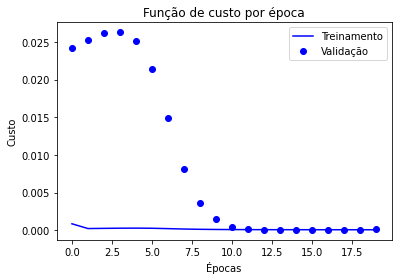

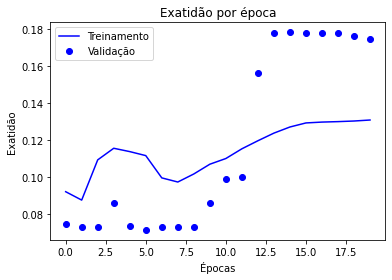

32 neuronios, camadas 2, otimizador adam, batch_size 16
Epoch 1/20
7052/7052 [==============================] - 325s 46ms/step - loss: 5.1511e-04 - accuracy: 0.1056 - val_loss: 0.0247 - val_accuracy: 0.0993
Epoch 2/20
7052/7052 [==============================] - 320s 45ms/step - loss: 2.2595e-04 - accuracy: 0.1097 - val_loss: 0.0257 - val_accuracy: 0.0728
Epoch 3/20
7052/7052 [==============================] - 319s 45ms/step - loss: 2.5741e-04 - accuracy: 0.1295 - val_loss: 0.0263 - val_accuracy: 0.0950
Epoch 4/20
7052/7052 [==============================] - 322s 46ms/step - loss: 2.7752e-04 - accuracy: 0.1317 - val_loss: 0.0255 - val_accuracy: 0.1774
Epoch 5/20
7052/7052 [==============================] - 320s 45ms/step - loss: 2.6715e-04 - accuracy: 0.1321 - val_loss: 0.0223 - val_accuracy: 0.1773
Epoch 6/20
7052/7052 [==============================] - 319s 45ms/step - loss: 2.1536e-04 - accuracy: 0.1281 - val_loss: 0.0157 - val_accuracy: 0.1774
Epoch 7/20
7052/7052 [================

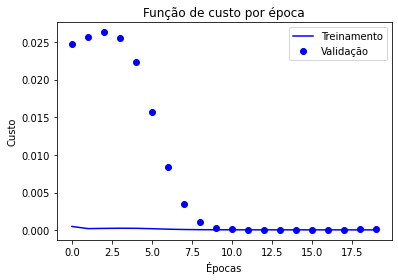

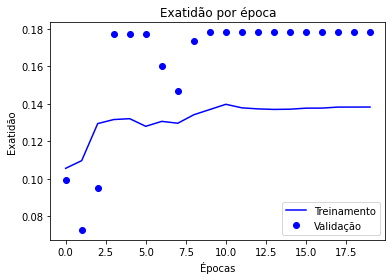

64 neuronios, camadas 2, otimizador adam, batch_size 16
Epoch 1/20
7052/7052 [==============================] - 438s 62ms/step - loss: 3.3303e-04 - accuracy: 0.1134 - val_loss: 0.0238 - val_accuracy: 0.0705
Epoch 2/20
7052/7052 [==============================] - 432s 61ms/step - loss: 2.2359e-04 - accuracy: 0.1083 - val_loss: 0.0257 - val_accuracy: 0.1774
Epoch 3/20
7052/7052 [==============================] - 437s 62ms/step - loss: 2.5400e-04 - accuracy: 0.1146 - val_loss: 0.0268 - val_accuracy: 0.1272
Epoch 4/20
7052/7052 [==============================] - 436s 62ms/step - loss: 2.9002e-04 - accuracy: 0.1099 - val_loss: 0.0273 - val_accuracy: 0.1215
Epoch 5/20
7052/7052 [==============================] - 437s 62ms/step - loss: 3.1198e-04 - accuracy: 0.1152 - val_loss: 0.0265 - val_accuracy: 0.1771
Epoch 6/20
7052/7052 [==============================] - 425s 60ms/step - loss: 2.8563e-04 - accuracy: 0.1049 - val_loss: 0.0226 - val_accuracy: 0.1772
Epoch 7/20
7052/7052 [================

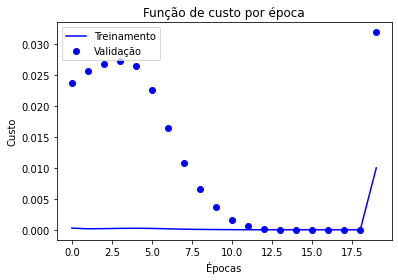

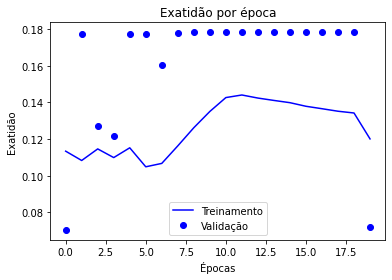

16 neuronios, camadas 3, otimizador adam, batch_size 16
Epoch 1/20
7052/7052 [==============================] - 473s 67ms/step - loss: 5.5538e-04 - accuracy: 0.0989 - val_loss: 0.0245 - val_accuracy: 0.0752
Epoch 2/20
7052/7052 [==============================] - 479s 68ms/step - loss: 2.3577e-04 - accuracy: 0.1043 - val_loss: 0.0255 - val_accuracy: 0.0728
Epoch 3/20
7052/7052 [==============================] - 478s 68ms/step - loss: 2.5874e-04 - accuracy: 0.1251 - val_loss: 0.0265 - val_accuracy: 0.1422
Epoch 4/20
7052/7052 [==============================] - 476s 67ms/step - loss: 2.8272e-04 - accuracy: 0.1325 - val_loss: 0.0271 - val_accuracy: 0.1774
Epoch 5/20
7052/7052 [==============================] - 494s 70ms/step - loss: 3.0346e-04 - accuracy: 0.1457 - val_loss: 0.0274 - val_accuracy: 0.1303
Epoch 6/20
7052/7052 [==============================] - 479s 68ms/step - loss: 3.1751e-04 - accuracy: 0.1477 - val_loss: 0.0275 - val_accuracy: 0.0788
Epoch 7/20
7052/7052 [================

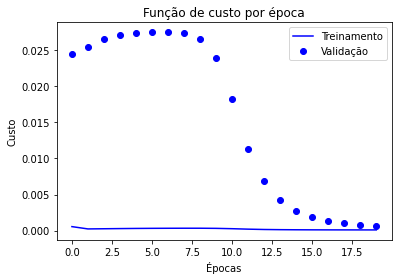

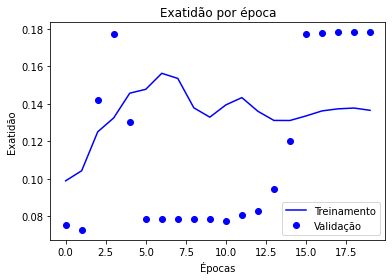

32 neuronios, camadas 3, otimizador adam, batch_size 16
Epoch 1/20
7052/7052 [==============================] - 482s 68ms/step - loss: 4.1443e-04 - accuracy: 0.0989 - val_loss: 0.0249 - val_accuracy: 0.0784
Epoch 2/20
7052/7052 [==============================] - 484s 69ms/step - loss: 2.3844e-04 - accuracy: 0.1066 - val_loss: 0.0264 - val_accuracy: 0.0784
Epoch 3/20
7052/7052 [==============================] - 477s 68ms/step - loss: 2.7941e-04 - accuracy: 0.1004 - val_loss: 0.0273 - val_accuracy: 0.0951
Epoch 4/20
7052/7052 [==============================] - 477s 68ms/step - loss: 3.0523e-04 - accuracy: 0.1082 - val_loss: 0.0275 - val_accuracy: 0.0783
Epoch 5/20
7052/7052 [==============================] - 475s 67ms/step - loss: 3.2178e-04 - accuracy: 0.1051 - val_loss: 0.0275 - val_accuracy: 0.0951
Epoch 6/20
 276/7052 [>.............................] - ETA: 7:09 - loss: 0.0028 - accuracy: 0.1048

In [0]:
for optmizer in optimizer_list:
    for batch_size in batch_list:
        for n_camadas in n_camadas_list:
            for n_neuronios in n_neurons_list:
                model = None
                model = cria_modelo( n_neuronios, n_camadas, optmizer, time_steps, nr_features, future_steps )
                
                print('{} neuronios, camadas {}, otimizador {}, batch_size {}'.format( n_neuronios, n_camadas, optmizer, batch_size ))

                historico = None
                historico = model.fit(X_treino, Y_treino, epochs=20, batch_size=batch_size, validation_data=(X_validacao, Y_validacao), shuffle=False)

                plota_treinamento(historico)

                escrever = 'numero de neuronios = {0}, numero de camadas = {1}, otimizador = {2}, batch size = {3}\n'.format( n_neuronios, n_camadas, optmizer, batch_size )
                escrever += 'valor minimo da funcao de custo do treino = {0}, valor minimo da funcao de custo da validacao = {1}\n'.format( min(historico.history['loss']), max(historico.history['val_loss']) )
                escrever += 'ultimo valor da funcao de custo do treino = {0}, ultimo valor da funcao de custo do validacao = {1}\n'.format( historico.history['loss'][-1], historico.history['val_loss'][-1] )
                escrever += 'valor maximo da exatidao do treino = {0}, valor maximo da exatidao da validacao = {1}\n'.format( min(historico.history['accuracy']), max(historico.history['val_accuracy']) )
                escrever += 'ultimo valor da exatidao do treino = {0}, ultimo exatidao de custo do validacao = {1}\n'.format( historico.history['accuracy'][-1], historico.history['val_accuracy'][-1] )
                with open(caminho_export + 'resultados.txt', 'a') as f:
                    f.write( escrever )

In [0]:
n_neurons_list = [ 32, 64 ]

n_camadas_list = [3]

optimizer_list = ['adam']

batch_list = [ 16 ]

32 neuronios, camadas 3, otimizador adam, batch_size 16
Epoch 1/20
7050/7050 [==============================] - 477s 68ms/step - loss: 7.2732e-04 - accuracy: 0.0278 - val_loss: 0.0240 - val_accuracy: 0.0185
Epoch 2/20
7050/7050 [==============================] - 470s 67ms/step - loss: 2.2393e-04 - accuracy: 0.0324 - val_loss: 0.0259 - val_accuracy: 0.0250
Epoch 3/20
7050/7050 [==============================] - 476s 67ms/step - loss: 2.5087e-04 - accuracy: 0.0335 - val_loss: 0.0270 - val_accuracy: 0.0191
Epoch 4/20
7050/7050 [==============================] - 477s 68ms/step - loss: 2.9230e-04 - accuracy: 0.0369 - val_loss: 0.0273 - val_accuracy: 0.0629
Epoch 5/20
7050/7050 [==============================] - 475s 67ms/step - loss: 3.0709e-04 - accuracy: 0.0609 - val_loss: 0.0273 - val_accuracy: 0.0629
Epoch 6/20
7050/7050 [==============================] - 473s 67ms/step - loss: 3.0899e-04 - accuracy: 0.0640 - val_loss: 0.0273 - val_accuracy: 0.0629
Epoch 7/20
7050/7050 [================

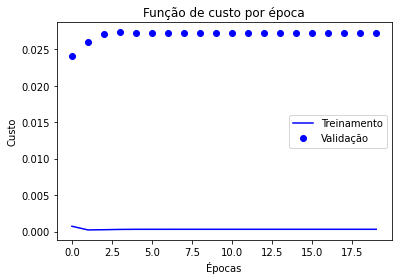

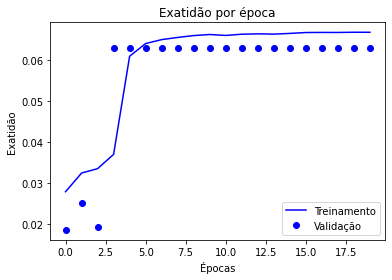

64 neuronios, camadas 3, otimizador adam, batch_size 16
Epoch 1/20
7050/7050 [==============================] - 646s 92ms/step - loss: 4.8740e-04 - accuracy: 0.0258 - val_loss: 0.0237 - val_accuracy: 0.0156
Epoch 2/20
7050/7050 [==============================] - 704s 100ms/step - loss: 2.2280e-04 - accuracy: 0.0322 - val_loss: 0.0269 - val_accuracy: 0.0222
Epoch 3/20
7050/7050 [==============================] - 675s 96ms/step - loss: 2.6778e-04 - accuracy: 0.0307 - val_loss: 0.0277 - val_accuracy: 0.0222
Epoch 4/20
7050/7050 [==============================] - 684s 97ms/step - loss: 3.2513e-04 - accuracy: 0.0271 - val_loss: 0.0277 - val_accuracy: 0.0629
Epoch 5/20
7050/7050 [==============================] - 676s 96ms/step - loss: 3.5213e-04 - accuracy: 0.0247 - val_loss: 0.0276 - val_accuracy: 0.0205
Epoch 6/20
7050/7050 [==============================] - 705s 100ms/step - loss: 3.6943e-04 - accuracy: 0.0335 - val_loss: 0.0276 - val_accuracy: 0.0205
Epoch 7/20
7050/7050 [==============

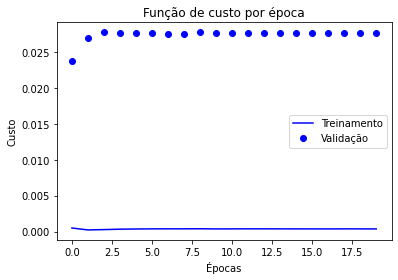

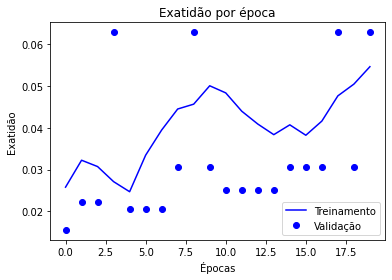

<Figure size 432x288 with 0 Axes>

In [0]:
for optmizer in optimizer_list:
    for batch_size in batch_list:
        for n_camadas in n_camadas_list:
            for n_neuronios in n_neurons_list:
                model = None
                model = cria_modelo( n_neuronios, n_camadas, optmizer, time_steps, nr_features, future_steps )
                
                print('{} neuronios, camadas {}, otimizador {}, batch_size {}'.format( n_neuronios, n_camadas, optmizer, batch_size ))

                historico = None
                historico = model.fit(X_treino, Y_treino, epochs=20, batch_size=batch_size, validation_data=(X_validacao, Y_validacao), shuffle=False)

                plota_treinamento(historico)

                escrever = 'numero de neuronios = {0}, numero de camadas = {1}, otimizador = {2}, batch size = {3}\n'.format( n_neuronios, n_camadas, optmizer, batch_size )
                escrever += 'valor minimo da funcao de custo do treino = {0}, valor minimo da funcao de custo da validacao = {1}\n'.format( min(historico.history['loss']), max(historico.history['val_loss']) )
                escrever += 'ultimo valor da funcao de custo do treino = {0}, ultimo valor da funcao de custo do validacao = {1}\n'.format( historico.history['loss'][-1], historico.history['val_loss'][-1] )
                escrever += 'valor maximo da exatidao do treino = {0}, valor maximo da exatidao da validacao = {1}\n'.format( min(historico.history['accuracy']), max(historico.history['val_accuracy']) )
                escrever += 'ultimo valor da exatidao do treino = {0}, ultimo exatidao de custo do validacao = {1}\n'.format( historico.history['accuracy'][-1], historico.history['val_accuracy'][-1] )
                with open(caminho_export + 'resultados.txt', 'a') as f:
                    f.write( escrever )

In [0]:
n_neurons_list = [ 16, 32, 64 ]

n_camadas_list = [1, 2, 3]

optimizer_list = ['adam', 'rmsprop']

batch_list = [ 32, 64 ]

16 neuronios, camadas 1, otimizador adam, batch_size 32
Epoch 1/20
3525/3525 [==============================] - 78s 22ms/step - loss: 0.0028 - accuracy: 0.0215 - val_loss: 0.0233 - val_accuracy: 0.0152
Epoch 2/20
3525/3525 [==============================] - 79s 22ms/step - loss: 3.9793e-04 - accuracy: 0.0241 - val_loss: 0.0220 - val_accuracy: 0.0177
Epoch 3/20
3525/3525 [==============================] - 78s 22ms/step - loss: 3.6106e-04 - accuracy: 0.0282 - val_loss: 0.0197 - val_accuracy: 0.0193
Epoch 4/20
3525/3525 [==============================] - 77s 22ms/step - loss: 3.2213e-04 - accuracy: 0.0284 - val_loss: 0.0177 - val_accuracy: 0.0189
Epoch 5/20
3525/3525 [==============================] - 77s 22ms/step - loss: 2.8137e-04 - accuracy: 0.0282 - val_loss: 0.0149 - val_accuracy: 0.0172
Epoch 6/20
3525/3525 [==============================] - 81s 23ms/step - loss: 2.4319e-04 - accuracy: 0.0264 - val_loss: 0.0118 - val_accuracy: 0.0191
Epoch 7/20
3525/3525 [==========================

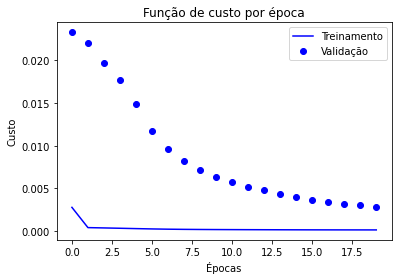

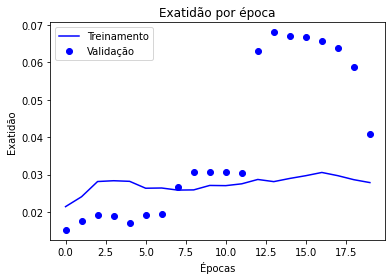

32 neuronios, camadas 1, otimizador adam, batch_size 32
Epoch 1/20
3525/3525 [==============================] - 89s 25ms/step - loss: 0.0018 - accuracy: 0.0223 - val_loss: 0.0260 - val_accuracy: 0.0212
Epoch 2/20
3525/3525 [==============================] - 91s 26ms/step - loss: 4.3513e-04 - accuracy: 0.0250 - val_loss: 0.0245 - val_accuracy: 0.0211
Epoch 3/20
3525/3525 [==============================] - 86s 24ms/step - loss: 4.0573e-04 - accuracy: 0.0221 - val_loss: 0.0230 - val_accuracy: 0.0154
Epoch 4/20
3525/3525 [==============================] - 87s 25ms/step - loss: 3.7268e-04 - accuracy: 0.0301 - val_loss: 0.0212 - val_accuracy: 0.0240
Epoch 5/20
3525/3525 [==============================] - 86s 24ms/step - loss: 3.2943e-04 - accuracy: 0.0280 - val_loss: 0.0183 - val_accuracy: 0.0147
Epoch 6/20
3525/3525 [==============================] - 86s 24ms/step - loss: 2.8618e-04 - accuracy: 0.0323 - val_loss: 0.0137 - val_accuracy: 0.0664
Epoch 7/20
3525/3525 [==========================

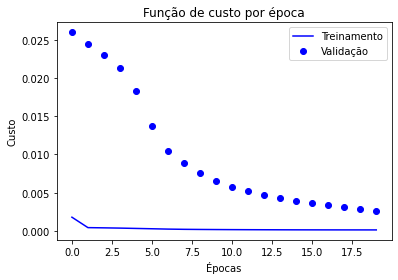

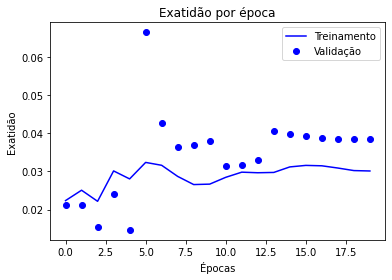

64 neuronios, camadas 1, otimizador adam, batch_size 32
Epoch 1/20
3525/3525 [==============================] - 108s 30ms/step - loss: 0.0012 - accuracy: 0.0196 - val_loss: 0.0269 - val_accuracy: 0.0243
Epoch 2/20
3525/3525 [==============================] - 111s 31ms/step - loss: 4.4879e-04 - accuracy: 0.0206 - val_loss: 0.0266 - val_accuracy: 0.0196
Epoch 3/20
3525/3525 [==============================] - 111s 31ms/step - loss: 4.4115e-04 - accuracy: 0.0211 - val_loss: 0.0253 - val_accuracy: 0.0163
Epoch 4/20
3525/3525 [==============================] - 110s 31ms/step - loss: 4.1993e-04 - accuracy: 0.0246 - val_loss: 0.0241 - val_accuracy: 0.0164
Epoch 5/20
3525/3525 [==============================] - 109s 31ms/step - loss: 3.9685e-04 - accuracy: 0.0254 - val_loss: 0.0228 - val_accuracy: 0.0162
Epoch 6/20
3525/3525 [==============================] - 109s 31ms/step - loss: 3.5485e-04 - accuracy: 0.0248 - val_loss: 0.0199 - val_accuracy: 0.0194
Epoch 7/20
3525/3525 [====================

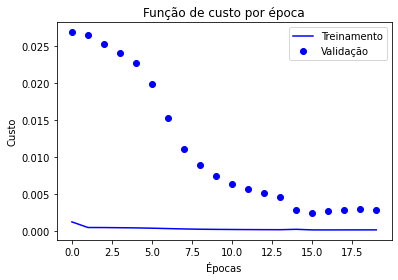

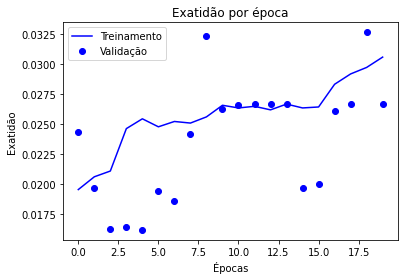

16 neuronios, camadas 2, otimizador adam, batch_size 32
Epoch 1/20
3525/3525 [==============================] - 156s 44ms/step - loss: 0.0024 - accuracy: 0.0179 - val_loss: 0.0263 - val_accuracy: 0.0164
Epoch 2/20
3525/3525 [==============================] - 155s 44ms/step - loss: 4.7178e-04 - accuracy: 0.0235 - val_loss: 0.0256 - val_accuracy: 0.0183
Epoch 3/20
3525/3525 [==============================] - 157s 45ms/step - loss: 4.5497e-04 - accuracy: 0.0225 - val_loss: 0.0247 - val_accuracy: 0.0243
Epoch 4/20
3525/3525 [==============================] - 156s 44ms/step - loss: 4.4146e-04 - accuracy: 0.0244 - val_loss: 0.0237 - val_accuracy: 0.0178
Epoch 5/20
3525/3525 [==============================] - 156s 44ms/step - loss: 4.2268e-04 - accuracy: 0.0235 - val_loss: 0.0224 - val_accuracy: 0.0173
Epoch 6/20
3525/3525 [==============================] - 155s 44ms/step - loss: 3.9519e-04 - accuracy: 0.0227 - val_loss: 0.0201 - val_accuracy: 0.0165
Epoch 7/20
3525/3525 [====================

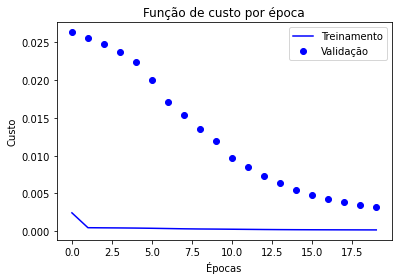

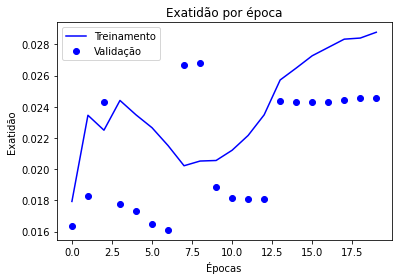

32 neuronios, camadas 2, otimizador adam, batch_size 32
Epoch 1/20
3525/3525 [==============================] - 169s 48ms/step - loss: 0.0015 - accuracy: 0.0231 - val_loss: 0.0277 - val_accuracy: 0.0217
Epoch 2/20
3525/3525 [==============================] - 171s 49ms/step - loss: 4.9864e-04 - accuracy: 0.0284 - val_loss: 0.0271 - val_accuracy: 0.0158
Epoch 3/20
3525/3525 [==============================] - 173s 49ms/step - loss: 4.9317e-04 - accuracy: 0.0329 - val_loss: 0.0263 - val_accuracy: 0.0180
Epoch 4/20
3525/3525 [==============================] - 173s 49ms/step - loss: 4.8851e-04 - accuracy: 0.0251 - val_loss: 0.0259 - val_accuracy: 0.0204
Epoch 5/20
3525/3525 [==============================] - 175s 50ms/step - loss: 4.8450e-04 - accuracy: 0.0282 - val_loss: 0.0256 - val_accuracy: 0.0207
Epoch 6/20
3525/3525 [==============================] - 182s 52ms/step - loss: 4.8379e-04 - accuracy: 0.0214 - val_loss: 0.0254 - val_accuracy: 0.0163
Epoch 7/20
3525/3525 [====================

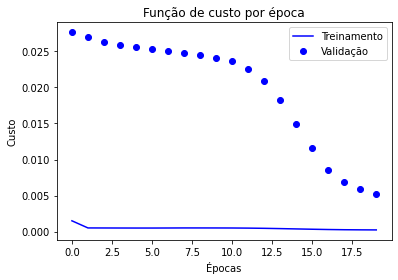

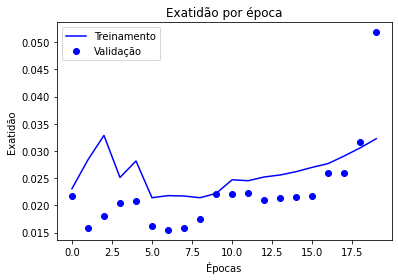

64 neuronios, camadas 2, otimizador adam, batch_size 32
Epoch 1/20
3525/3525 [==============================] - 235s 67ms/step - loss: 9.9226e-04 - accuracy: 0.0241 - val_loss: 0.0278 - val_accuracy: 0.0143
Epoch 2/20
3525/3525 [==============================] - 235s 67ms/step - loss: 4.7659e-04 - accuracy: 0.0205 - val_loss: 0.0263 - val_accuracy: 0.0204
Epoch 3/20
3525/3525 [==============================] - 237s 67ms/step - loss: 4.8398e-04 - accuracy: 0.0205 - val_loss: 0.0269 - val_accuracy: 0.0156
Epoch 4/20
3525/3525 [==============================] - 235s 67ms/step - loss: 5.1488e-04 - accuracy: 0.0204 - val_loss: 0.0273 - val_accuracy: 0.0205
Epoch 5/20
3525/3525 [==============================] - 237s 67ms/step - loss: 5.5862e-04 - accuracy: 0.0215 - val_loss: 0.0276 - val_accuracy: 0.0216
Epoch 6/20
3525/3525 [==============================] - 235s 67ms/step - loss: 6.0151e-04 - accuracy: 0.0242 - val_loss: 0.0277 - val_accuracy: 0.0225
Epoch 7/20
3525/3525 [================

In [0]:
plt.style.use('seaborn')

for optmizer in optimizer_list:
    for batch_size in batch_list:
        for n_camadas in n_camadas_list:
            for n_neuronios in n_neurons_list:
                model = None
                model = cria_modelo( n_neuronios, n_camadas, optmizer, time_steps, nr_features, future_steps )
                
                print('{} neuronios, camadas {}, otimizador {}, batch_size {}'.format( n_neuronios, n_camadas, optmizer, batch_size ))

                historico = None
                historico = model.fit(X_treino, Y_treino, epochs=20, batch_size=batch_size, validation_data=(X_validacao, Y_validacao), shuffle=False)

                plota_treinamento(historico)

                escrever = 'numero de neuronios = {0}, numero de camadas = {1}, otimizador = {2}, batch size = {3}\n'.format( n_neuronios, n_camadas, optmizer, batch_size )
                escrever += 'valor minimo da funcao de custo do treino = {0}, valor minimo da funcao de custo da validacao = {1}\n'.format( min(historico.history['loss']), max(historico.history['val_loss']) )
                escrever += 'ultimo valor da funcao de custo do treino = {0}, ultimo valor da funcao de custo do validacao = {1}\n'.format( historico.history['loss'][-1], historico.history['val_loss'][-1] )
                escrever += 'valor maximo da exatidao do treino = {0}, valor maximo da exatidao da validacao = {1}\n'.format( min(historico.history['accuracy']), max(historico.history['val_accuracy']) )
                escrever += 'ultimo valor da exatidao do treino = {0}, ultimo exatidao de custo do validacao = {1}\n'.format( historico.history['accuracy'][-1], historico.history['val_accuracy'][-1] )
                with open(caminho_export + 'resultados.txt', 'a') as f:
                    f.write( escrever )

Depois de ter rodado todo o algoritmo percebi que escrevi os mínimos e máximos errados quando deveria escrever no arquivo, por isso usaremos apenas os últimos valores como referência.

Por falta de tempo não foi possível treinar todos os valores dos hyperparametros que gostariamos, mas conseguimos variar a quantidade de camadas e de neurônios da rede, e podemos deduzir que o melhor resultado foi com 64 neurônios em apenas 1 camada, onde obtivemos os seguintes resultados:

- último valor da funcao de custo do treino = 0.0001268215710297227
- último valor da funcao de custo do validacao = 0.0028301889542490244
- último valor da exatidao do treino = 0.030571170151233673
- último exatidao de custo do validacao = 0.026658914983272552

Os próximos testes então foram feitos com esses valores de neurônios e camadas.

Para tentar corrigir o problema da rede estar "shiftando" os valores, colocaremos o valor de future_steps maior que o de time_steps, afim de não deixar ela lembrar dos valores e sim tentar prever o que vem pela frente.

Realizaremos um promeiro teste com time_steps = 30 e future_steps = 100

In [0]:
time_steps = 30
future_steps = 100
X_treino, Y_treino, X_validacao, Y_validacao, X_teste, Y_teste = prepara_steps( time_steps, future_steps )

In [0]:
model = cria_modelo( 64, 1, 'adam', time_steps, nr_features, future_steps )

historico = model.fit(X_treino, Y_treino, epochs=30, batch_size=time_steps, validation_data=(X_validacao, Y_validacao), shuffle=False, callbacks=callbacks)

Epoch 1/30
3759/3759 [==============================] - 67s 18ms/step - loss: 0.0011 - accuracy: 0.0124 - val_loss: 0.0295 - val_accuracy: 0.0141
Epoch 2/30
3759/3759 [==============================] - 67s 18ms/step - loss: 4.4644e-04 - accuracy: 0.0155 - val_loss: 0.0292 - val_accuracy: 0.0113
Epoch 3/30
3759/3759 [==============================] - 67s 18ms/step - loss: 4.6752e-04 - accuracy: 0.0170 - val_loss: 0.0275 - val_accuracy: 0.0079
Epoch 4/30
3759/3759 [==============================] - 67s 18ms/step - loss: 4.6128e-04 - accuracy: 0.0190 - val_loss: 0.0265 - val_accuracy: 0.0077
Epoch 5/30
3759/3759 [==============================] - 67s 18ms/step - loss: 4.4815e-04 - accuracy: 0.0213 - val_loss: 0.0254 - val_accuracy: 0.0182
Epoch 6/30
3759/3759 [==============================] - 68s 18ms/step - loss: 4.3068e-04 - accuracy: 0.0199 - val_loss: 0.0247 - val_accuracy: 0.0199
Epoch 7/30
3759/3759 [==============================] - 69s 18ms/step - loss: 4.0902e-04 - accuracy: 0.0

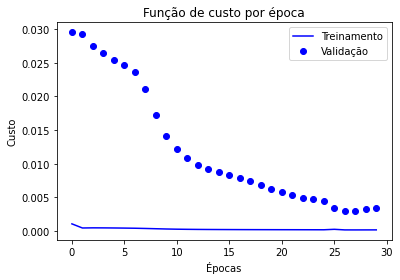

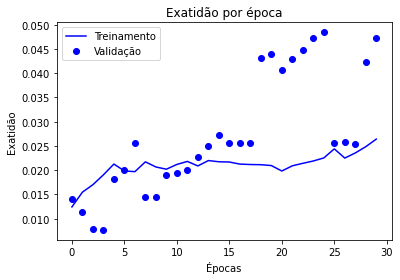

<Figure size 432x288 with 0 Axes>

In [0]:
plota_treinamento(historico)

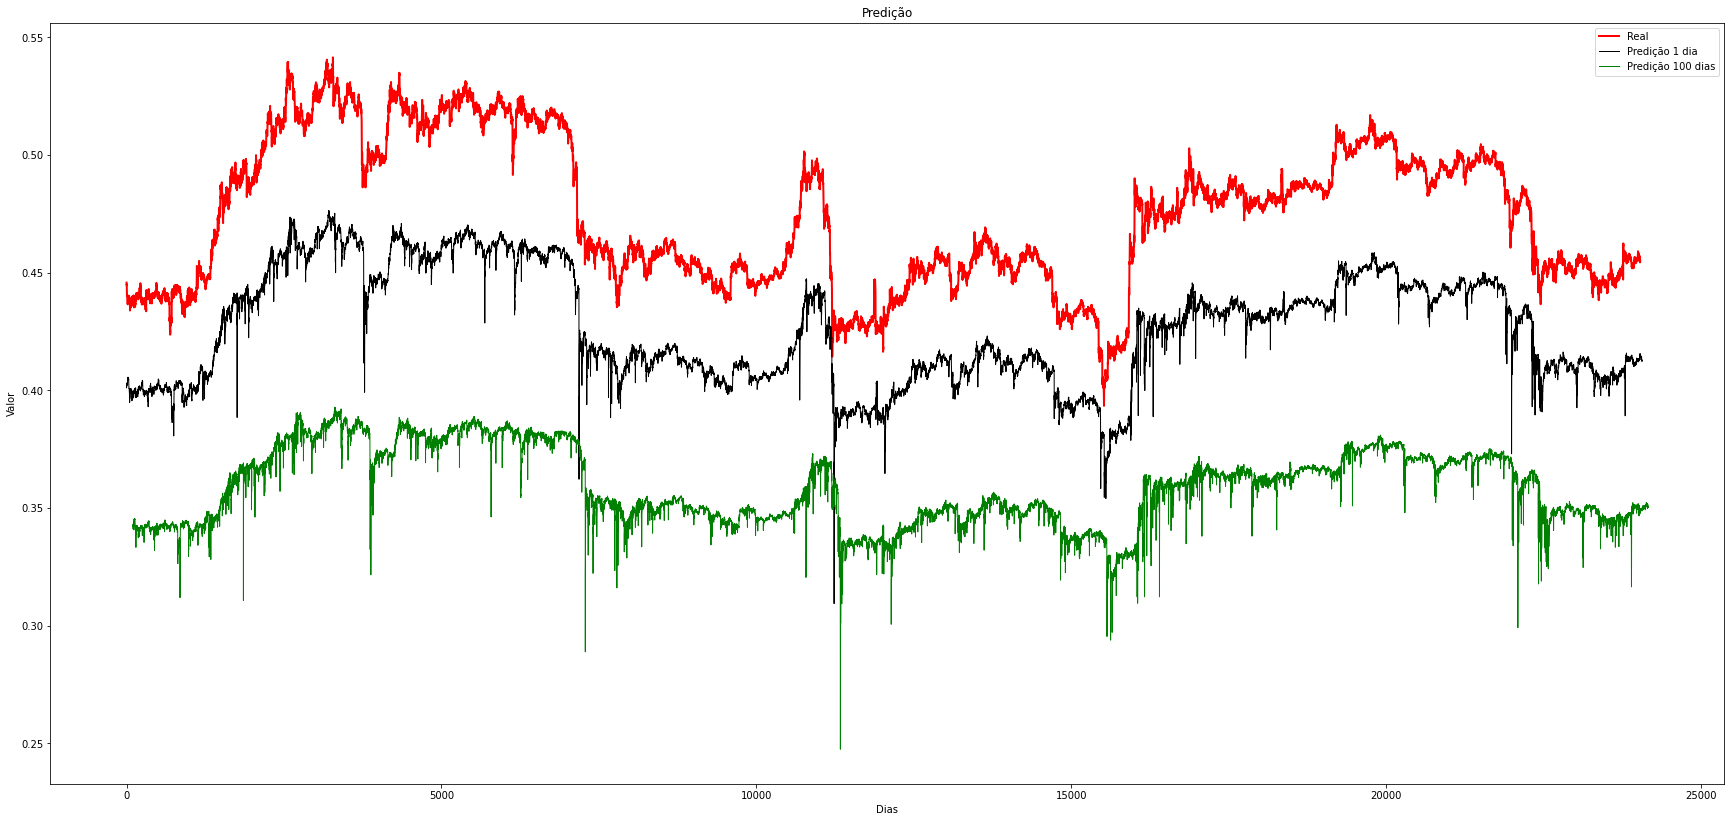

In [0]:
Y_predict = model.predict( X_teste )
plota_predicao( [100], ['green'] )

Observando o gráfico gerado vemos que realmente a rede não está "shiftando" tão bem os valores quanto antes, mas o problema de graneza ainda persiste.

A visualização desse gráfico não é uma métrica muito boa de se utilizar, por isso vamos utilizar dois valores para comparação:
- diferença entre o valor real e o previsto (erro)
- diferença entre o valor real no tempo t e no tempo t-1

Dessa forma, se o primeiro valor for maior que o segundo, ainda temos um modelo bem longe do ideal, porem, se o primeiro valor for menor que o segundo, temos um modelo que está caminhando para o ideal.

In [0]:
def calcula_erro():
    erro = np.mean(Y_teste - Y_predict)

    erro_t_vetor = []
    for  i in range(1, len(Y_teste)):
        erro_t_vetor.append( Y_teste[i] - Y_teste[i-1] )
    erro_t = np.mean(erro_t_vetor)

    return erro, erro_t

In [0]:
erro, erro_t = calcula_erro()
print('Erro       = {0:.8f}'.format( erro ))
print('Erro t - 1 = {0:.8f}'.format( erro_t ))

Erro       = 0.08467241
Erro t - 1 = 0.00000060


Agora alem da exatidão temos essa nova métrica para perceber que nosso algoritmo não está com um resultado bom.

Vamos definir um problema com valores pequenos para conseguirmos treinar mais variações de redes.

In [0]:
time_steps = 10
future_steps = 30
X_treino, Y_treino, X_validacao, Y_validacao, X_teste, Y_teste = prepara_steps( time_steps, future_steps )

In [0]:
n_neurons_list = [ 32, 64, 128, 256, 512 ]

n_camadas_list = [ 1, 2, 3 ]

32 neuronios, camadas 1
Epoch 1/20
11286/11286 [==============================] - 67s 6ms/step - loss: 6.1042e-04 - accuracy: 0.0409 - val_loss: 0.0228 - val_accuracy: 0.0242
Epoch 2/20
11286/11286 [==============================] - 66s 6ms/step - loss: 1.4305e-04 - accuracy: 0.0435 - val_loss: 0.0226 - val_accuracy: 0.0243
Epoch 3/20
11286/11286 [==============================] - 67s 6ms/step - loss: 1.4622e-04 - accuracy: 0.0489 - val_loss: 0.0215 - val_accuracy: 0.0239
Epoch 4/20
11286/11286 [==============================] - 68s 6ms/step - loss: 1.4146e-04 - accuracy: 0.0504 - val_loss: 0.0199 - val_accuracy: 0.0238
Epoch 5/20
11286/11286 [==============================] - 68s 6ms/step - loss: 1.3476e-04 - accuracy: 0.0496 - val_loss: 0.0183 - val_accuracy: 0.0242
Epoch 6/20
11286/11286 [==============================] - 70s 6ms/step - loss: 1.2341e-04 - accuracy: 0.0457 - val_loss: 0.0158 - val_accuracy: 0.0249
Epoch 7/20
11286/11286 [==============================] - 68s 6ms/step

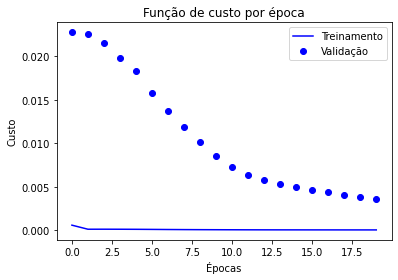

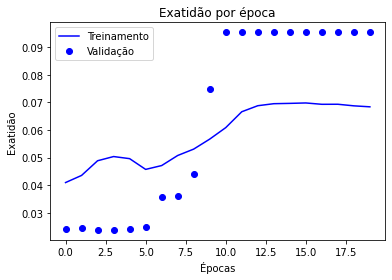

64 neuronios, camadas 1
Epoch 1/20
11286/11286 [==============================] - 71s 6ms/step - loss: 3.3496e-04 - accuracy: 0.0459 - val_loss: 0.0245 - val_accuracy: 0.0474
Epoch 2/20
11286/11286 [==============================] - 70s 6ms/step - loss: 1.4443e-04 - accuracy: 0.0530 - val_loss: 0.0243 - val_accuracy: 0.0448
Epoch 3/20
11286/11286 [==============================] - 70s 6ms/step - loss: 1.5418e-04 - accuracy: 0.0613 - val_loss: 0.0238 - val_accuracy: 0.0399
Epoch 4/20
11286/11286 [==============================] - 73s 6ms/step - loss: 1.5454e-04 - accuracy: 0.0602 - val_loss: 0.0227 - val_accuracy: 0.0358
Epoch 5/20
11286/11286 [==============================] - 70s 6ms/step - loss: 1.5456e-04 - accuracy: 0.0595 - val_loss: 0.0209 - val_accuracy: 0.0357
Epoch 6/20
11286/11286 [==============================] - 71s 6ms/step - loss: 1.4840e-04 - accuracy: 0.0585 - val_loss: 0.0183 - val_accuracy: 0.0941
Epoch 7/20
11286/11286 [==============================] - 71s 6ms/step

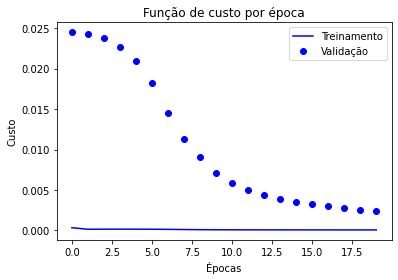

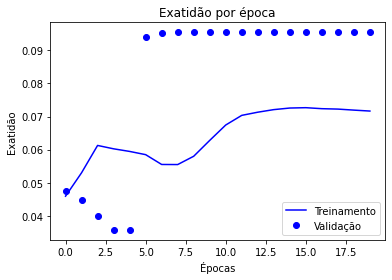

128 neuronios, camadas 1
Epoch 1/20
11286/11286 [==============================] - 121s 11ms/step - loss: 2.6064e-04 - accuracy: 0.0426 - val_loss: 0.0244 - val_accuracy: 0.0331
Epoch 2/20
11286/11286 [==============================] - 121s 11ms/step - loss: 1.4042e-04 - accuracy: 0.0535 - val_loss: 0.0238 - val_accuracy: 0.0330
Epoch 3/20
11286/11286 [==============================] - 123s 11ms/step - loss: 1.4738e-04 - accuracy: 0.0558 - val_loss: 0.0232 - val_accuracy: 0.0411
Epoch 4/20
11286/11286 [==============================] - 124s 11ms/step - loss: 1.4418e-04 - accuracy: 0.0538 - val_loss: 0.0213 - val_accuracy: 0.0411
Epoch 5/20
11286/11286 [==============================] - 124s 11ms/step - loss: 1.4798e-04 - accuracy: 0.0524 - val_loss: 0.0203 - val_accuracy: 0.0538
Epoch 6/20
11286/11286 [==============================] - 127s 11ms/step - loss: 1.4386e-04 - accuracy: 0.0481 - val_loss: 0.0171 - val_accuracy: 0.0522
Epoch 7/20
11286/11286 [==============================] -

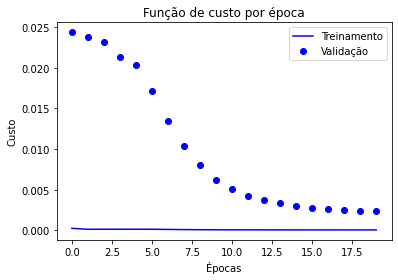

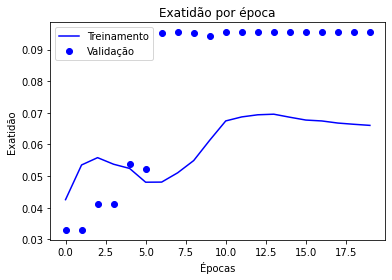

256 neuronios, camadas 1
Epoch 1/20
11286/11286 [==============================] - 255s 23ms/step - loss: 2.0314e-04 - accuracy: 0.0449 - val_loss: 0.0252 - val_accuracy: 0.0363
Epoch 2/20
11286/11286 [==============================] - 254s 23ms/step - loss: 1.4011e-04 - accuracy: 0.0610 - val_loss: 0.0246 - val_accuracy: 0.0523
Epoch 3/20
11286/11286 [==============================] - 272s 24ms/step - loss: 1.5151e-04 - accuracy: 0.0615 - val_loss: 0.0242 - val_accuracy: 0.0523
Epoch 4/20
11286/11286 [==============================] - 273s 24ms/step - loss: 1.5474e-04 - accuracy: 0.0587 - val_loss: 0.0231 - val_accuracy: 0.0395
Epoch 5/20
11286/11286 [==============================] - 265s 23ms/step - loss: 1.4452e-04 - accuracy: 0.0580 - val_loss: 0.0208 - val_accuracy: 0.0391
Epoch 6/20
11286/11286 [==============================] - 263s 23ms/step - loss: 1.4184e-04 - accuracy: 0.0559 - val_loss: 0.0217 - val_accuracy: 0.0951
Epoch 7/20
11286/11286 [==============================] -

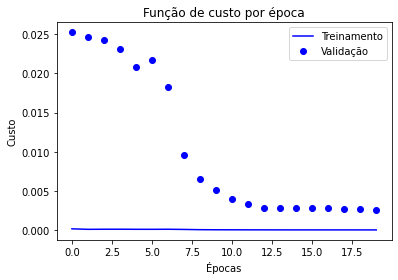

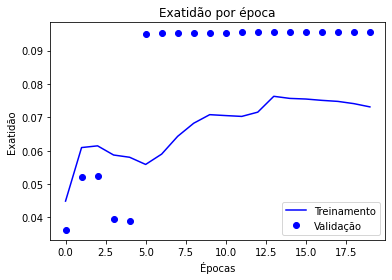

512 neuronios, camadas 1
Epoch 1/20
11286/11286 [==============================] - 749s 66ms/step - loss: 1.7738e-04 - accuracy: 0.0457 - val_loss: 0.0251 - val_accuracy: 0.0955
Epoch 2/20
11286/11286 [==============================] - 749s 66ms/step - loss: 1.3658e-04 - accuracy: 0.0643 - val_loss: 0.0246 - val_accuracy: 0.0956
Epoch 3/20
11286/11286 [==============================] - 765s 68ms/step - loss: 1.5150e-04 - accuracy: 0.0741 - val_loss: 0.0242 - val_accuracy: 0.0954
Epoch 4/20
11286/11286 [==============================] - 797s 71ms/step - loss: 1.5282e-04 - accuracy: 0.0725 - val_loss: 0.0229 - val_accuracy: 0.0954
Epoch 5/20
11286/11286 [==============================] - 815s 72ms/step - loss: 1.5658e-04 - accuracy: 0.0718 - val_loss: 0.0211 - val_accuracy: 0.0411
Epoch 6/20
11286/11286 [==============================] - 849s 75ms/step - loss: 1.5881e-04 - accuracy: 0.0707 - val_loss: 0.0200 - val_accuracy: 0.0955
Epoch 7/20
11286/11286 [==============================] -

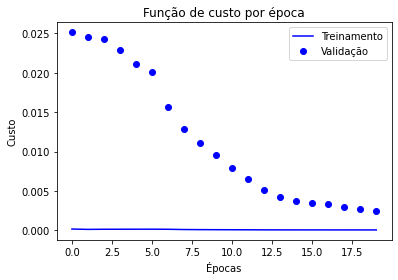

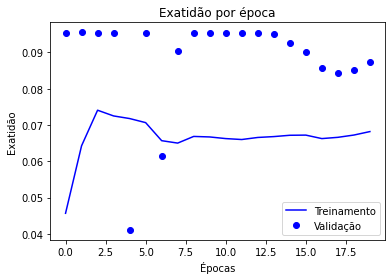

32 neuronios, camadas 2
Epoch 1/20
11286/11286 [==============================] - 119s 11ms/step - loss: 4.5969e-04 - accuracy: 0.0407 - val_loss: 0.0233 - val_accuracy: 0.0272
Epoch 2/20
11286/11286 [==============================] - 119s 11ms/step - loss: 1.5442e-04 - accuracy: 0.0419 - val_loss: 0.0239 - val_accuracy: 0.0274
Epoch 3/20
11286/11286 [==============================] - 122s 11ms/step - loss: 1.7425e-04 - accuracy: 0.0451 - val_loss: 0.0248 - val_accuracy: 0.0275
Epoch 4/20
11286/11286 [==============================] - 120s 11ms/step - loss: 1.8607e-04 - accuracy: 0.0477 - val_loss: 0.0251 - val_accuracy: 0.0274
Epoch 5/20
11286/11286 [==============================] - 119s 11ms/step - loss: 1.9125e-04 - accuracy: 0.0572 - val_loss: 0.0248 - val_accuracy: 0.0274
Epoch 6/20
11286/11286 [==============================] - 119s 11ms/step - loss: 1.9035e-04 - accuracy: 0.0617 - val_loss: 0.0248 - val_accuracy: 0.0274
Epoch 7/20
11286/11286 [==============================] - 

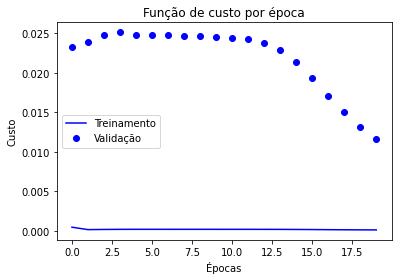

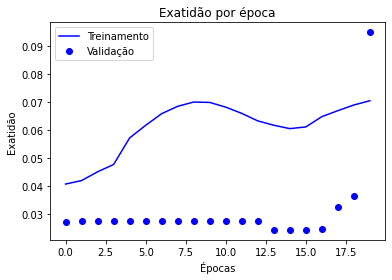

64 neuronios, camadas 2
Epoch 1/20
11286/11286 [==============================] - 138s 12ms/step - loss: 3.0522e-04 - accuracy: 0.0464 - val_loss: 0.0233 - val_accuracy: 0.0344
Epoch 2/20
11286/11286 [==============================] - 137s 12ms/step - loss: 1.4862e-04 - accuracy: 0.0541 - val_loss: 0.0232 - val_accuracy: 0.0311
Epoch 3/20
11286/11286 [==============================] - 135s 12ms/step - loss: 1.6750e-04 - accuracy: 0.0620 - val_loss: 0.0241 - val_accuracy: 0.0318
Epoch 4/20
11286/11286 [==============================] - 139s 12ms/step - loss: 1.7988e-04 - accuracy: 0.0663 - val_loss: 0.0246 - val_accuracy: 0.0300
Epoch 5/20
11286/11286 [==============================] - 137s 12ms/step - loss: 1.8418e-04 - accuracy: 0.0636 - val_loss: 0.0249 - val_accuracy: 0.0399
Epoch 6/20
11286/11286 [==============================] - 138s 12ms/step - loss: 1.9085e-04 - accuracy: 0.0635 - val_loss: 0.0253 - val_accuracy: 0.0411
Epoch 7/20
11286/11286 [==============================] - 

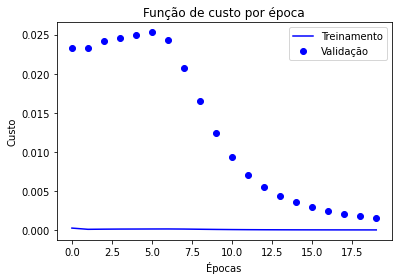

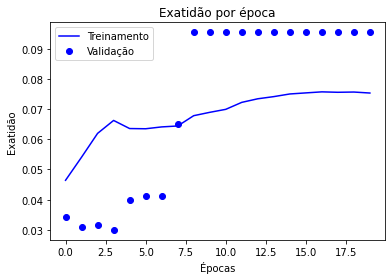

128 neuronios, camadas 2
Epoch 1/20
11286/11286 [==============================] - 251s 22ms/step - loss: 2.2086e-04 - accuracy: 0.0428 - val_loss: 0.0236 - val_accuracy: 0.0258
Epoch 2/20
11286/11286 [==============================] - 245s 22ms/step - loss: 1.4401e-04 - accuracy: 0.0536 - val_loss: 0.0229 - val_accuracy: 0.0289
Epoch 3/20
11286/11286 [==============================] - 246s 22ms/step - loss: 1.6518e-04 - accuracy: 0.0559 - val_loss: 0.0238 - val_accuracy: 0.0258
Epoch 4/20
11286/11286 [==============================] - 249s 22ms/step - loss: 1.7712e-04 - accuracy: 0.0603 - val_loss: 0.0249 - val_accuracy: 0.0951
Epoch 5/20
11286/11286 [==============================] - 244s 22ms/step - loss: 1.8941e-04 - accuracy: 0.0632 - val_loss: 0.0266 - val_accuracy: 0.0358
Epoch 6/20
11286/11286 [==============================] - 247s 22ms/step - loss: 2.1241e-04 - accuracy: 0.0627 - val_loss: 0.0269 - val_accuracy: 0.0359
Epoch 7/20
11286/11286 [==============================] -

In [0]:
for n_camadas in n_camadas_list:
    for n_neuronios in n_neurons_list:
        model = None
        model = cria_modelo( n_neuronios, n_camadas, 'adam', time_steps, nr_features, future_steps )
        
        print('{} neuronios, camadas {}'.format( n_neuronios, n_camadas ))

        historico = None
        historico = model.fit(X_treino, Y_treino, epochs=20, batch_size=time_steps, validation_data=(X_validacao, Y_validacao), shuffle=False)

        plota_treinamento(historico)

        Y_predict = model.predict( X_teste )
        erro, erro_t = calcula_erro()

        escrever = 'numero de neuronios = {0}, numero de camadas = {1}\n'.format( n_neuronios, n_camadas )
        escrever += 'valor minimo da funcao de custo do treino = {0}, valor minimo da funcao de custo da validacao = {1}\n'.format( min(historico.history['loss']), min(historico.history['val_loss']) )
        escrever += 'ultimo valor da funcao de custo do treino = {0}, ultimo valor da funcao de custo do validacao = {1}\n'.format( historico.history['loss'][-1], historico.history['val_loss'][-1] )
        escrever += 'valor maximo da exatidao do treino = {0}, valor maximo da exatidao da validacao = {1}\n'.format( max(historico.history['accuracy']), max(historico.history['val_accuracy']) )
        escrever += 'ultimo valor da exatidao do treino = {0}, ultimo exatidao de custo do validacao = {1}\n'.format( historico.history['accuracy'][-1], historico.history['val_accuracy'][-1] )
        escrever += 'erro = {0}, erro t - 1 = {1}\n\n\n'.format( erro, erro_t )
        with open(caminho_export + 'resultados.txt', 'a') as f:
            f.write( escrever )

In [0]:
time_steps = 10
future_steps = 30
X_treino, Y_treino, X_validacao, Y_validacao, X_teste, Y_teste = prepara_steps( time_steps, future_steps )

In [0]:
n_neurons_list = [ 128, 256, 512 ]

n_camadas_list = [ 2, 3 ]

128 neuronios, camadas 2
Epoch 1/20
11286/11286 [==============================] - 241s 21ms/step - loss: 2.2594e-04 - accuracy: 0.0418 - val_loss: 0.0232 - val_accuracy: 0.0955
Epoch 2/20
11286/11286 [==============================] - 244s 22ms/step - loss: 1.5871e-04 - accuracy: 0.0507 - val_loss: 0.0235 - val_accuracy: 0.0364
Epoch 3/20
11286/11286 [==============================] - 240s 21ms/step - loss: 1.7014e-04 - accuracy: 0.0785 - val_loss: 0.0235 - val_accuracy: 0.0898
Epoch 4/20
11286/11286 [==============================] - 240s 21ms/step - loss: 1.7144e-04 - accuracy: 0.0872 - val_loss: 0.0235 - val_accuracy: 0.0898
Epoch 5/20
11286/11286 [==============================] - 245s 22ms/step - loss: 1.7146e-04 - accuracy: 0.0873 - val_loss: 0.0235 - val_accuracy: 0.0898
Epoch 6/20
11286/11286 [==============================] - 240s 21ms/step - loss: 1.7146e-04 - accuracy: 0.0873 - val_loss: 0.0235 - val_accuracy: 0.0898
Epoch 7/20
11286/11286 [==============================] -

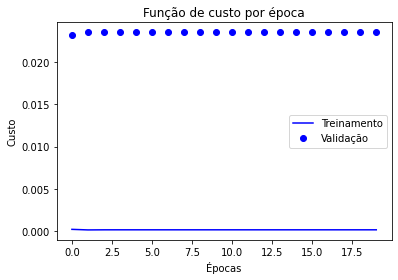

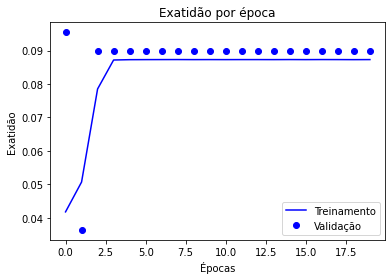

NameError: ignored

<Figure size 432x288 with 0 Axes>

In [0]:
for n_camadas in n_camadas_list:
    for n_neuronios in n_neurons_list:
        model = None
        model = cria_modelo( n_neuronios, n_camadas, 'adam', time_steps, nr_features, future_steps )
        
        print('{} neuronios, camadas {}'.format( n_neuronios, n_camadas ))

        historico = None
        historico = model.fit(X_treino, Y_treino, epochs=20, batch_size=time_steps, validation_data=(X_validacao, Y_validacao), shuffle=False)

        plota_treinamento(historico)

        Y_predict = model.predict( X_teste )
        erro, erro_t = calcula_erro()

        escrever = 'numero de neuronios = {0}, numero de camadas = {1}\n'.format( n_neuronios, n_camadas )
        escrever += 'valor minimo da funcao de custo do treino = {0}, valor minimo da funcao de custo da validacao = {1}\n'.format( min(historico.history['loss']), min(historico.history['val_loss']) )
        escrever += 'ultimo valor da funcao de custo do treino = {0}, ultimo valor da funcao de custo do validacao = {1}\n'.format( historico.history['loss'][-1], historico.history['val_loss'][-1] )
        escrever += 'valor maximo da exatidao do treino = {0}, valor maximo da exatidao da validacao = {1}\n'.format( max(historico.history['accuracy']), max(historico.history['val_accuracy']) )
        escrever += 'ultimo valor da exatidao do treino = {0}, ultimo exatidao de custo do validacao = {1}\n'.format( historico.history['accuracy'][-1], historico.history['val_accuracy'][-1] )
        escrever += 'erro = {0}, erro t - 1 = {1}\n\n\n'.format( erro, erro_t )
        with open(caminho_export + 'resultados.txt', 'a') as f:
            f.write( escrever )

Depois de rodar mais testes com mais neurônios e camadas, não foi possivel ver um ganho relevante, por isso vamos continuar a usar 64 neurônios em apenas 1 camada.

Vamos por fim treinar uma rede por mais épocas e ver o resultado final, tendo uma rede relativamente simples e com um resultado satisfatório para o problema considerado.

In [0]:
time_steps = 10
future_steps = 30
X_treino, Y_treino, X_validacao, Y_validacao, X_teste, Y_teste = prepara_steps( time_steps, future_steps )

model = cria_modelo( 64, 1, 'adam', time_steps, nr_features, future_steps )

historico = model.fit(X_treino, Y_treino, epochs=100, batch_size=time_steps, validation_data=(X_validacao, Y_validacao), shuffle=False)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 64)                18432     
_________________________________________________________________
dense_12 (Dense)             (None, 30)                1950      
Total params: 20,382
Trainable params: 20,382
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
11286/11286 [==============================] - 63s 6ms/step - loss: 3.8010e-04 - accuracy: 0.0408 - val_loss: 0.0246 - val_accuracy: 0.0330
Epoch 2/100
11286/11286 [==============================] - 62s 5ms/step - loss: 1.4731e-04 - accuracy: 0.0471 - val_loss: 0.0245 - val_accuracy: 0.0253
Epoch 3/100
11286/11286 [==============================] - 62s 6ms/step - loss: 1.5734e-04 - accuracy: 0.0488 - val_loss: 0.0242 - val_accuracy: 0.0237
Epoch 4/100
11286/11286 [==============================

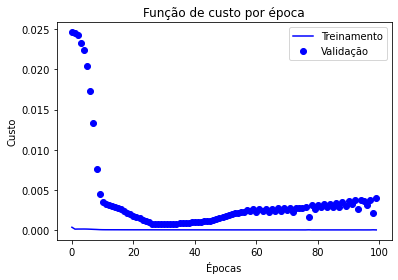

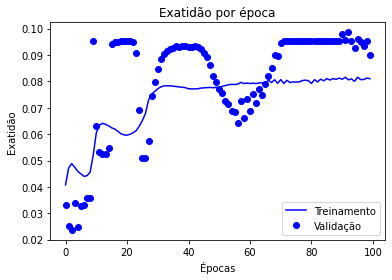

Erro       = 0.07142700
Erro t - 1 = 0.00000048


<Figure size 432x288 with 0 Axes>

In [0]:
plota_treinamento(historico)

Y_predict = model.predict( X_teste )
erro, erro_t = calcula_erro()

print('Erro       = {0:.8f}'.format( erro ))
print('Erro t - 1 = {0:.8f}'.format( erro_t ))

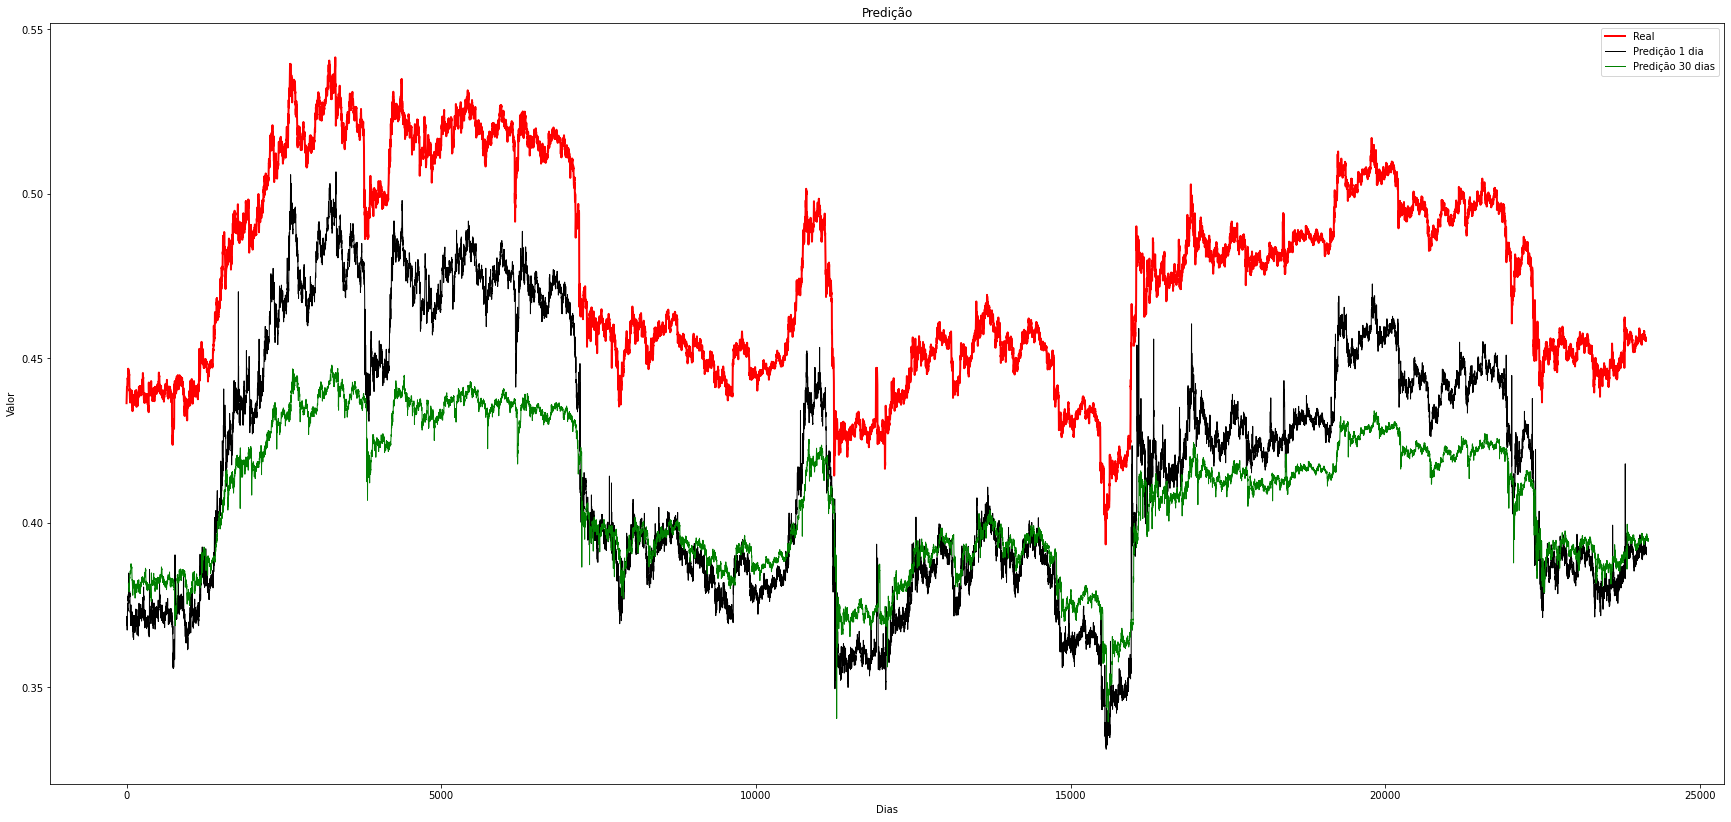

In [0]:
Y_predict = model.predict( X_teste )
plota_predicao( [30], ['green'] )

Os valores da bolsa de valores são muito difíceis de prever pois temos muita influência externa da qual é complicado de monitorar, e os valores de bitcoin são ainda mais difíceis por se tratar de uma tecnologia nova e que o mundo inteiro tem acesso, fazendo com que a influência externa seja gigante.

Com isso em mente, e sabendo que não foi utilizado recursos de ponta no desenvolvimento desse projeto, podemos dizer que o resultado foi satisfatório.